### 讀取資料

In [35]:
from pandas import read_csv
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


### 資料預處理

In [36]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### 探索資料

Populating the interactive namespace from numpy and matplotlib


/Users/davidchiu/.pyenv/versions/3.6.2/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


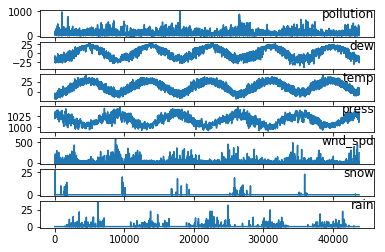

In [37]:
%pylab inline
from matplotlib import pyplot
values = dataset.values

groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### 資料轉換

In [38]:
import pandas
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### 資料編碼

In [39]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')

### 正規化特徵

In [40]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)


### 捨棄掉不需要預測的欄位

In [41]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


### 分為訓練與測試資料集

In [42]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((8760, 1, 8), (8760,), (35039, 1, 8), (35039,))

### 建立模型

In [43]:
import keras
from keras import layers


model = keras.models.Sequential()
model.add(layers.LSTM(50, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.LSTM(50, return_sequences = True))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

### 訓練模型

In [44]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0585 - val_loss: 0.0486
Epoch 2/50
 - 1s - loss: 0.0389 - val_loss: 0.0451
Epoch 3/50
 - 1s - loss: 0.0221 - val_loss: 0.0386
Epoch 4/50
 - 1s - loss: 0.0170 - val_loss: 0.0328
Epoch 5/50
 - 1s - loss: 0.0156 - val_loss: 0.0213
Epoch 6/50
 - 1s - loss: 0.0149 - val_loss: 0.0169
Epoch 7/50
 - 1s - loss: 0.0148 - val_loss: 0.0161
Epoch 8/50
 - 1s - loss: 0.0150 - val_loss: 0.0157
Epoch 9/50
 - 1s - loss: 0.0147 - val_loss: 0.0148
Epoch 10/50
 - 1s - loss: 0.0146 - val_loss: 0.0145
Epoch 11/50
 - 1s - loss: 0.0145 - val_loss: 0.0141
Epoch 12/50
 - 1s - loss: 0.0145 - val_loss: 0.0140
Epoch 13/50
 - 1s - loss: 0.0145 - val_loss: 0.0142
Epoch 14/50
 - 1s - loss: 0.0146 - val_loss: 0.0141
Epoch 15/50
 - 1s - loss: 0.0145 - val_loss: 0.0139
Epoch 16/50
 - 1s - loss: 0.0145 - val_loss: 0.0139
Epoch 17/50
 - 1s - loss: 0.0145 - val_loss: 0.0139
Epoch 18/50
 - 1s - loss: 0.0145 - val_loss: 0.0138
Epoch 19/50
 - 1s - loss

### 繪製損失圖

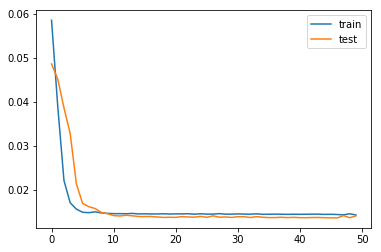

In [45]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### 產生預測

In [48]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


### 反正規化資料

In [5]:
import numpy as np
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

NameError: name 'yhat' is not defined

### 計算RMSE

In [6]:
# calculate RMSE
from keras.backend import sqrt
from keras import losses
rmse = sqrt(losses.mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'inv_y' is not defined